<center>
<h1 style="font-family:verdana">
 💻 🧑 Classificació d'intencions 🧑 💻


<p> 🎯 <b>Objectiu</b>: en aquesta pràctica aprendrem a detectar la intenció de l'usuari a partir d'interaccions reals amb un xatbot. En el context de xatbots, la classificació d'intencions ajuda a entendre quina acció o resposta hauria de prendre el sistema en funció de la consulta de l'usuari.  


<p> ✨ <b>Contingut</b>: en primer lloc, farem servir una base de dades amb oracions d'interaccions en espanyol etiquetades com 19 intencions diferents. En segon lloc, realitzarem el preprocessament de les dades, és a dir, transformarem les dades perquè tinguen un format adequat per a ser introduïdes al model. I finalment, dissenyarem i entrenarem el model de classificació per detectar automàticament la intenció de les oracions.</p>  


<p> ✏ <b>Exercicis</b>: en cada secció anireu trobant exercicis que haureu d'anar resolent. </p>



---

<h2> Índex </h2>

1. [Inspecció del conjunt de dades](#section-one)
  * [Exercici 1](#ex-one)
2. [Preprocessament de dades](#section-two)
  * [Exercici 2](#ex-two)
  * [Exercici 3](#ex-three)
3. [Disseny del model i entrenament](#section-three)
  * [Exercici 4](#ex-four)
  * [Exercici 5](#ex-five)
4. [Lliurable](#section-four)
---

In [59]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D, Dropout, Conv1D, GlobalAveragePooling1D, LayerNormalization #Remove
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import time  

import nltk
import pandas as pd
from nltk.corpus import wordnet,stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lukag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lukag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lukag\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t"
!tar -zxf nlu_ATIS_data.tar.gz


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Downloading...
From: https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t
To: c:\Users\lukag\OneDrive\Desktop\Universidad\3ero\cuadrimestre1\TVD\TVD_Practica_2\nlu_ATIS_data.tar.gz

  0%|          | 0.00/122k [00:00<?, ?B/s]
100%|██████████| 122k/122k [00:00<00:00, 1.77MB/s]


<h1><a name="section-one"> 1. Inspecció del conjunt de dades </a></h1>

A la carpeta `data` tenim els diferents fitxers CSV que utilitzarem per a aquesta pràctica.

En primer lloc, llegirem les dades dels fitxers CSV amb `pandas`.

In [3]:
train_data = pd.read_csv('./data/train.csv', header=None)
val_data = train_data.tail(900)
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)
test_data = pd.read_csv('./data/test.csv', header=None)

print('Training size:', len(train_data))
print('Validation dataset size:', len(val_data))
print('Test dataset size:', len(test_data))

Training size: 4078
Validation dataset size: 900
Test dataset size: 893


Per a aquesta primera part de la pràctica ens centrarem en la primera columna dels arxius que correspon amb les **oracions** en anglès introduïdes per l'usuari. I en la tercera columna que correspon amb la **intenció** de cada oració, és a dir, cada oració tindrà una etiqueta.

Podeu executar la cel·la següent tantes vegades com vulgueu per veure instàncies d'aquest conjunt de dades.


In [4]:
random_number = random.randint(0, len(train_data)-1)

train_sentences = list(train_data[0])
train_labels = list(s.replace('"', '') for s in train_data[2])
train_labels = list(s.replace(' ', '') for s in train_labels)

print('Sentence: ', train_sentences[random_number])
print('Intent: ', train_labels[random_number])

Sentence:  what is the earliest flight leaving boston on july first to dallas on july first
Intent:  flight


A continuació analitzarem quantes etiquetes diferents hi ha al dataset i quines són.

In [5]:
num_labels = 0
for label in set(train_labels):
  print(f'Label {num_labels}:', label.split('.')[-1])
  num_labels += 1

print(f'\nThere are a total of {num_labels} intent labels')

Label 0: restriction
Label 1: meal
Label 2: ground_service
Label 3: abbreviation
Label 4: airport
Label 5: airfare+flight_time
Label 6: airline
Label 7: airfare
Label 8: airline+flight_no
Label 9: aircraft+flight+flight_no
Label 10: ground_service+ground_fare
Label 11: distance
Label 12: cheapest
Label 13: flight_time
Label 14: capacity
Label 15: quantity
Label 16: city
Label 17: aircraft
Label 18: flight
Label 19: flight_no
Label 20: ground_fare
Label 21: flight+airfare

There are a total of 22 intent labels


<h1><a name="section-two"> 2. Preprocessament de dades </a></h1>

En primer lloc, haurem de tokenitzar les oracions. Això consisteix a convertir el text en representacions numèriques, ja que els models esperen unitats discretes.

En aquesta pràctica farem servir una tokenització senzilla, simplement dividirem les oracions en paraules i crearem un vocabulari basat en les paraules úniques de les dades d'entrenament. Cada paraula (token) tindrà assignat un ID únic.

Vegem com queda el vocabulari.

In [6]:
num_words=500
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(train_sentences)

vocab = tokenizer.word_index
print(vocab)

{'to': 1, 'from': 2, 'flights': 3, 'the': 4, 'on': 5, 'what': 6, 'me': 7, 'flight': 8, 'boston': 9, 'show': 10, 'san': 11, 'i': 12, 'denver': 13, 'a': 14, 'francisco': 15, 'in': 16, 'and': 17, 'atlanta': 18, 'pittsburgh': 19, 'is': 20, 'dallas': 21, 'baltimore': 22, 'all': 23, 'philadelphia': 24, 'like': 25, 'are': 26, 'list': 27, 'airlines': 28, 'of': 29, 'between': 30, 'that': 31, 'washington': 32, 'leaving': 33, 'please': 34, 'pm': 35, 'morning': 36, 'would': 37, 'fly': 38, 'for': 39, 'fare': 40, 'first': 41, 'wednesday': 42, 'after': 43, 'there': 44, 'oakland': 45, "'d": 46, 'ground': 47, 'you': 48, 'does': 49, 'trip': 50, 'transportation': 51, 'class': 52, 'arriving': 53, 'cheapest': 54, 'need': 55, 'city': 56, 'round': 57, 'with': 58, 'before': 59, 'which': 60, 'available': 61, 'have': 62, 'give': 63, 'at': 64, 'fares': 65, 'american': 66, 'afternoon': 67, 'one': 68, 'want': 69, 'how': 70, 'way': 71, 'new': 72, 'dc': 73, 'nonstop': 74, 'arrive': 75, 'earliest': 76, 'york': 77, 'g

---

 <h1><a name="ex-one"><center> ✏ Exercici 1 ✏</a></h1>

En aquest primer exercici us demanem que donat el vocabulari anterior convertiu la llista d'oracions de la partició d'entrenament, és a dir, `train_sentenes` en seqüències d'IDs.

Podeu trobar la documentació [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).

In [7]:

train_sequences = tokenizer.texts_to_sequences(train_sentences)

print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]


Si ho heu fet correctament hauríeu d'obtenir això:

```
print(train_sentences[0])
print(train_sequences[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
[12, 69, 1, 38, 2, 9, 64, 415, 84, 17, 75, 16, 13, 64, 493, 16, 4, 36]
```



---
A continuació haurem d'aconseguir que totes les seqüències tinguen una longitud fixa. Per a fer això primer fixarem la longitud segons la longitud màxima trobada a les seqüències del conjunt d'entrenament. I a continuació omplirem (*pad*) les seqüències que tinguen una longitud menor.


In [8]:
max_sequence_length = max(map(len, train_sequences))
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)
print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  12  69   1  38   2   9  64 415  84
  17  75  16  13  64 493  16   4  36]


---

 <h1><a name="ex-two"><center> ✏ Exercici 2 ✏</a></h1>

Com l'ordre de les paraules sí que importa als models que utilitzarem en aquesta pràctica, és aconsellable que el *padding* estiga al final i no al principi. Busqueu [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) com fer perquè el codi anterior afegisca els zeros al final i no al principi de la seqüència.

In [9]:
#TODO
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
print('Padded sequence: ', train_pad_sequences[0])

Padded sequence:  [ 12  69   1  38   2   9  64 415  84  17  75  16  13  64 493  16   4  36
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


---

A continuació convertirem les classes d'intencions categòriques (*capacity*, *ground_service*, *flight*, etc.) en el que anomenem one-hot vector encoding. Aquesta tècnica s'utilitza per representar les dades categòriques com a vectors binaris. On cada vector representa una classe específica i l'element corresponent a la classe es posa a 1 i la resta d'elements es mantenen a 0.

Imaginem que tenim tres classes: *capacity*, *ground_service*, *flight*. Podríem codificar aquestes classes amb un vector únic de la forma següent:


```
   capacity -> [1, 0, 0]
   ground_service -> [0, 1, 0]
   flight -> [0, 0, 1]
```

Per aconseguir això primer codificarem les classes d'intenció en etiquetes numèriques.

In [10]:
label_encoder = LabelEncoder()
train_numerical_labels = label_encoder.fit_transform(train_labels)

print(f'Original labels: {train_labels}\n')
print(f'Encoded labels: {train_numerical_labels} \n')

Original labels: ['flight', 'flight', 'flight_time', 'airfare', 'airfare', 'flight', 'aircraft', 'flight', 'flight', 'ground_service', 'flight', 'flight', 'airport', 'flight', 'flight', 'airfare', 'ground_service', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'airline', 'flight', 'ground_service', 'flight', 'airfare', 'flight', 'flight', 'flight', 'flight', 'airfare', 'airline', 'flight', 'flight', 'flight', 'distance', 'flight', 'airline', 'airline', 'flight', 'airline', 'ground_service', 'abbreviation', 'flight', 'flight', 'flight_time', 'flight', 'flight', 'ground_fare', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'ground_service', 'airline', 'flight', 'flight', 'airport', 'flight', 'flight', 'abbreviation', 'flight', 'flight', 'flight', 'flight', 'aircraft', 'airfare', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'flight', 'airline', 'flight', 'flight', 'flight', 'fli

I a continuació convertim les etiquetes a vectors one-hot.

In [11]:
num_classes = len(np.unique(train_numerical_labels))
train_encoded_labels = to_categorical(train_numerical_labels, num_classes)

print('Example: \n')
print(f'Original label: {train_labels[0]}\n')
print(f'Numerical label: {train_numerical_labels[0]}\n')
print(f'One-hot: {train_encoded_labels[0]}\n')

Example: 

Original label: flight

Numerical label: 12

One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]



---

 <h1><a name="ex-three"><center> ✏ Exercici 3 ✏</a></h1>

Amb la partició de validació i test haurem de realitzar els mateixos passos. Per tant, en aquest exercici us demanem que obtingueu `val_pad_sequences`, `val_encoded_labels`, `test_pad_sequences` i `test_encoded_labels`.

In [12]:
def preprocess_sentences(sentences, tokenizer, max_sequence_length):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    return padded_sequences

In [13]:
def preprocess_labels(labels, label_encoder):

    numerical_labels = label_encoder.transform(labels)
    one_hot_labels = to_categorical(numerical_labels, num_classes)
    return one_hot_labels

In [14]:

val_pad_sequences = preprocess_sentences(val_data[0], tokenizer, max_sequence_length)
test_pad_sequences = preprocess_sentences(test_data[0], tokenizer, max_sequence_length)


In [15]:
val_labels = list(s.replace('"', '') for s in val_data[2])
val_labels = list(s.replace(' ', '') for s in val_labels)

test_labels = list(s.replace('"', '') for s in test_data[2])
test_labels = list(s.replace(' ', '') for s in test_labels)

def remove_values_and_indices(input_list, values_to_remove, other_list):
    indices_to_remove = [idx for idx, item in enumerate(input_list) if item in values_to_remove]
    cleaned_list = [item for item in input_list if item not in values_to_remove]
    cleaned_other_list = [item for idx, item in enumerate(other_list) if idx not in indices_to_remove]
    return cleaned_list, np.array(cleaned_other_list)

values_to_remove = ['day_name','airfare+flight','flight+airline','flight_no+airline']
val_labels, val_pad_sequences = remove_values_and_indices(val_labels, values_to_remove, val_pad_sequences)
test_labels, test_pad_sequences = remove_values_and_indices(test_labels, values_to_remove, test_pad_sequences)


In [16]:
val_encoded_labels = preprocess_labels(val_labels, label_encoder)
test_encoded_labels = preprocess_labels(test_labels, label_encoder)

---

<h1><a name="section-three"> 3. Disseny del model i entrenament </a></h1>

En primer lloc, anem a comprovar si hi ha GPUs disponibles. A continuació si hi ha GPUs disponibles el codi assegurarà que *TensorFlow* només assigne memòria GPU quan siga necessari.

In [17]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("GPU is not available. The model will be trained on CPU.")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

GPU is not available. The model will be trained on CPU.


---

 <h1><a name="ex-four"><center> ✏ Exercici 4 ✏</a></h1>

En aquest exercici haureu de dissenyar l'arquitectura del model. El nostre model tindrà quatre capes:

1. La primera capa serà un **embedding**. Aquesta capa permetrà convertir les dades de text d'entrada, en vectors densos amb una mida fixa (*embedding_dim*). Aquesta representació més compacta permetrà per una part capturar la informació semàntica del text d'entrada, permetent així generalitzar millor i comprendre les relacions entre les paraules. I, per una altra banda, reduir la complexitat computacional, accelerant així el temps d'entrenament i inferència. En resum, aquesta capa assignarà a cada índex de cada paraula un vector dens de mida *embedding_dim*.

2. La segona capa serà un **pooling** layer. L'entrada d'aquesta capa serà un tensor 3D (*batch_size*, *sequence_length*, *embedding_dim*). Aquesta capa es centrarà a capturar la informació més important de la seqüència d'entrada, és a dir, prendrà el valor màxim de la seqüència, donant lloc a un tensor 2D (batch_size, embedding_dim).

3. La tercera capa serà una capa **densa**. És a dir, una capa completament connectada (*fully-connected*): cada neurona d'aquesta capa estarà connectada a totes les neurones de la capa anterior. La funció d'activació que utilitzarem serà una ReLU. Aquesta funció introdueix una no-linealitat al model permetent així aprendre relacions complexes en les dades.

4. L'última capa també serà una capa **densa**. En aquest cas la funció d'activació haurà de ser la funció Softmax. Aquesta funció es fa servir per a convertir els valors de la capa anterior (*logits*) en probabilitats normalitzades. El valor de cada element de sortida representarà la probabilitat que l'entrada pertanya a una classe específica.


📢  Les capes que haureu de fer servir les podreu trobar [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/layers).





In [18]:
embedding_dim = 100
vocab_size = num_words + 1 # 0 is reserved for unknown words

model = Sequential()
model.add(Embedding( vocab_size,embedding_dim)) #layer 1
model.add(GlobalAveragePooling1D()) #layer 2
model.add(Dense(128, activation='relu')) #layer 3
model.add(Dense(22,activation='softmax')) #layer 4

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 40
history = model.fit(train_pad_sequences, train_encoded_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_pad_sequences, val_encoded_labels))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_pad_sequences, test_encoded_labels, batch_size=batch_size)
print(f"Test accuracy: {accuracy:.2f}")


Epoch 1/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7123 - loss: 1.6227 - val_accuracy: 0.7144 - val_loss: 1.1851
Epoch 2/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7378 - loss: 1.0803 - val_accuracy: 0.7144 - val_loss: 0.9765
Epoch 3/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7570 - loss: 0.8558 - val_accuracy: 0.7733 - val_loss: 0.8237
Epoch 4/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8028 - loss: 0.7171 - val_accuracy: 0.8100 - val_loss: 0.7260
Epoch 5/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8271 - loss: 0.6343 - val_accuracy: 0.8322 - val_loss: 0.6400
Epoch 6/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8592 - loss: 0.5359 - val_accuracy: 0.8333 - val_loss: 0.5937
Epoch 7/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8642 - loss: 0.5122 - val_accuracy: 0.8711 - val_loss: 0.5387
Epoch 8/40
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8732 - loss: 0.4852 - val_accuracy: 0.

Podeu veure a continuació les oracions que el model ha classificat incorrectament.

In [19]:
test_sentences = list(test_data[0])

probs = model.predict(test_pad_sequences)
_predicted_labels = np.argmax(probs, axis=1)
predicted_labels = label_encoder.inverse_transform(_predicted_labels)

for i in range(0, len(predicted_labels)):
  if test_labels[i] != predicted_labels[i]:
    print('Sentence: ', test_sentences[i])
    print('Original label: ', test_labels[i])
    print('Predicted label: ', predicted_labels[i])
    print()


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Sentence:  show flight and prices kansas city to chicago on next wednesday arriving in chicago by 7 pm
Original label:  flight+airfare
Predicted label:  airfare

Sentence:  i need a flight from tampa to milwaukee
Original label:  meal
Predicted label:  flight

Sentence:  i need a flight from milwaukee to seattle
Original label:  meal
Predicted label:  flight

Sentence:  please find a flight from orlando to kansas city
Original label:  airport
Predicted label:  ground_service

Sentence:  what is the latest flight from baltimore to oakland that serves dinner
Original label:  city
Predicted label:  flight

Sentence:  show me all flights from seattle to boston with stopovers in minneapolis
Original label:  flight
Predicted label:  aircraft

Sentence:  i need to get from cincinnati to denver on june sixth by 6 pm
Original label:  ground_fare
Predicted label:  airfare

Sentence:  what 's the ground transportation in denver
Original label:  ground_fare
P

---

 <h1><a name="ex-five"><center> ✏ Exercici 5 ✏ </a></h1>

Modifiqueu els següents paràmetres del model anterior i analitzeu com afecten a la seva *accuracy*:

 1. **Preprocessament.** Modifiqueu el Tokenizer per canviar la mida del vostre vocabulari i afegiu nous passos de preprocessament. Alguns possibles canvis són canviar la mida del vocabulari, treure la capitalització o fer servir *lemmatització* o *stemming*.

 2. **Mida dels Embeddings.** Proveu diferents mides d'*Embeddings* i observeu com canvia l'*accuracy* del model. Heu d'explicar les vostres conclusions.

 3. **Xarxes Convolucionals.** Afegiu capes convolucionals al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació a l'hora d'escollir-los. Recordeu, que també podeu provar diferents configuracions de *pooling*.

 4. **Xarxes Recurrents.**  Afegiu capes recurrents al vostre model (LSTM, GRU). Expliqueu amb detall els valors que heu provat i la vostra motivació.

 5. **Regularització.** Quan proveu configuracions amb més paràmetres veureu que el model comença a tenir *overfitting* molt prompte durant l'entrenament. Afegiu *Dropout* al vostre model. Heu d'explicar la vostra decisió de valors i de posició dins de la xarxa.

 6. **Balancejat de les classes.** Si analitzeu el dataset, veureu que la freqüència de les classes està molt desbalancejada. Keras us permet afegir un pes per a cada classe a l'hora de calcular la loss (Mireu el paràmetre "class_weigth" a la documentació https://keras.io/api/models/model_training_apis/). Calculeu un pes per a cada classe i afegiu-lo al mètode fit del vostre model.

 ---

## Funcions Generals

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

test_sentences = list(test_data[0])

# funcion para listar las predicciones incorrectas
def incorrect_predictions(model, test_pad_sequences, test_labels, test_sentences):
    probs = model.predict(test_pad_sequences)
    _predicted_labels = np.argmax(probs, axis=1)
    predicted_labels = label_encoder.inverse_transform(_predicted_labels)

    for i in range(0, len(predicted_labels)):
        if test_labels[i] != predicted_labels[i]:
            print('Sentence: ', test_sentences[i])
            print('Original label: ', test_labels[i])
            print('Predicted label: ', predicted_labels[i])
            print()

    return None

# funcion para graficar el accuracy
def plot_accuracy(history):
    """
    Función para graficar el accuracy de entrenamiento y validación.
    
    Argumentos:
    - history: El historial del entrenamiento devuelto por 'model.fit()'.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(8, 6))
    sns.lineplot(x=epochs_range, y=acc, label='Training Accuracy')
    sns.lineplot(x=epochs_range, y=val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# funcion para graficar el loss
def plot_loss(history):
    """
    Función para graficar el loss de entrenamiento y validación.
    
    Argumentos:
    - history: El historial del entrenamiento devuelto por 'model.fit()'.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 6))
    sns.lineplot(x=epochs_range, y=loss, label='Training Loss')
    sns.lineplot(x=epochs_range, y=val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()



## Experiment 1: canvi de preprocessament

### Funció de preprocés

farem una funció senzilla per no repetir codi, on ens dedicarem a fer flags per els preprocessos que volem. Farem els següents canvis en el preprocés:

- canviar la mida del vocabulari 
- treure la capitalització
- fer servir *lemmatització* o *stemming*.
- treure stop-words

In [31]:
def preprocessing(train_sentences,sentences,vocab_size,lemmatize,not_capitalize,stop_words):

    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        train_sentences = [' '.join([lemmatizer.lemmatize(word) for word in sentence.split()]) for sentence in train_sentences]
        sentences = [' '.join([lemmatizer.lemmatize(word) for word in sentence.split()]) for sentence in sentences]
    
    if not_capitalize:
        train_sentences = [sentence.lower() for sentence in train_sentences]
        sentences = [sentence.lower() for sentence in sentences]
    
    if stop_words:
        stop_words = set(stopwords.words('english'))
        train_sentences = [' '.join([word for word in sentence.split() if word not in stop_words]) for sentence in train_sentences]
        sentences = [' '.join([word for word in sentence.split() if word not in stop_words]) for sentence in sentences]
    
    if vocab_size == 'all':
        tokenizer = Tokenizer()
    else:
        tokenizer = Tokenizer(num_words=vocab_size)

    tokenizer.fit_on_texts(train_sentences)

    train_sequences = tokenizer.texts_to_sequences(train_sentences)
    max_sequence_length = max(map(len, train_sequences))
    
    padded_sequences = preprocess_sentences(sentences, tokenizer, max_sequence_length)
    
    if vocab_size == 'all':
        return padded_sequences,len(tokenizer.word_index) + 1
    else:
        return padded_sequences

    
    
    

Ara guardem els resultats de accuracy de train i validació donat les combinacions de preprocés que són possibles

### Estudi del Preprocés

In [32]:
train_sentences = list(train_data[0])
val_sentences = list(val_data[0])

In [33]:
batch_size = 32
epochs = 20

vocab_size = [100, 500, 'all']
lemmatize = [True, False]
not_capitalize = [True, False]
stop_words = [True, False]

resultados = []

for v in vocab_size:
    for l in lemmatize:
        for c in not_capitalize:
            for s in stop_words:
                print(f'Vocab size: {v}, Lemmatize: {l}, Not capitalize: {c}, Stop words: {s}')

                if v == 'all':
                    train_pad_sequences,vocab_size = preprocessing(train_sentences, train_sentences, v, l, c, s)
                    val_pad_sequences,_ = preprocessing(train_sentences, val_sentences, v, l, c, s)
                else:

                    train_pad_sequences = preprocessing(train_sentences, train_sentences, v, l, c, s)
                    val_pad_sequences = preprocessing(train_sentences, val_sentences, v, l, c, s)
                    vocab_size = v

                model = Sequential()

                model.add(Embedding( vocab_size,embedding_dim)) #layer 1
                model.add(GlobalAveragePooling1D()) #layer 2
                model.add(Dense(128, activation='relu')) #layer 3
                model.add(Dense(22,activation='softmax')) #layer 4

                # Compile the model
                model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
                     
                history = model.fit(train_pad_sequences, train_encoded_labels, 
                                    batch_size=batch_size, epochs=epochs, 
                                    validation_data=(val_pad_sequences, val_encoded_labels))
                
                resultados.append({
                    'Vocab Size': v,
                    'Lemmatize': l,
                    'Not Capitalize': c,
                    'Stop Words': s,
                    'Train Accuracy': history.history['accuracy'][-1],
                    'Validation Accuracy': history.history['val_accuracy'][-1]
                })

df_resultados = pd.DataFrame(resultados)


Vocab size: 100, Lemmatize: True, Not capitalize: True, Stop words: True
Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7026 - loss: 1.7497 - val_accuracy: 0.7144 - val_loss: 1.1768
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7435 - loss: 1.0293 - val_accuracy: 0.7378 - val_loss: 0.9240
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7978 - loss: 0.8017 - val_accuracy: 0.8133 - val_loss: 0.7702
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8224 - loss: 0.7121 - val_accuracy: 0.8211 - val_loss: 0.6964
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8443 - loss: 0.6076 - val_accuracy: 0.8400 - val_loss: 0.6372
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8510 - loss: 0.5855 - val_accuracy: 0.8533 - val_loss: 0.6110
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8561 - loss: 0.5713 - val_accuracy: 0.8578 - val_loss: 0.5827
Epoch 8/20
128/128 ━━━━━━━━━━━━

Millors resultats

In [40]:
df_resultados.sort_values(by='Validation Accuracy', ascending=False).head(10)

,Vocab Size,Lemmatize,Not Capitalize,Stop Words,Train Accuracy,Validation Accuracy
17,all,True,True,False,0.956596,0.937778
19,all,True,False,False,0.954880,0.935556
20,all,False,True,True,0.952428,0.932222
16,all,True,True,True,0.962482,0.932222
12,500,False,True,True,0.961255,0.931111
22,all,False,False,True,0.956351,0.930000
11,500,True,False,False,0.949240,0.928889
23,all,False,False,False,0.949240,0.928889
14,500,False,False,True,0.955616,0.926667
13,500,False,True,False,0.956106,0.925556


pitjors resultats

In [41]:
df_resultados.sort_values(by='Validation Accuracy', ascending=True).head(10)

,Vocab Size,Lemmatize,Not Capitalize,Stop Words,Train Accuracy,Validation Accuracy
7,100,False,False,False,0.897008,0.885556
5,100,False,True,False,0.895047,0.887778
1,100,True,True,False,0.904365,0.888889
4,100,False,True,True,0.887445,0.891111
6,100,False,False,True,0.887200,0.893333
3,100,True,False,False,0.900441,0.894444
2,100,True,False,True,0.906817,0.895556
0,100,True,True,True,0.907062,0.898889
15,500,False,False,False,0.944090,0.917778
9,500,True,True,False,0.949485,0.921111


els millors resultats els dona quan fem servir tot el vocabulari, lemmatitzem i treiem majúscules. En les següents experiments tindrem en compte aquest canvis

## Experiment 2: Mida dels embeddings

In [ ]:
# Millor preprocessament del experiment anterior

train_pad_sequences,vocab_size = preprocessing(train_sentences, train_sentences, 'all', True, True, False)
val_pad_sequences,_ = preprocessing(train_sentences, val_sentences, 'all', True, True, False)



In [60]:
embedding_dim = [50, 100, 200, 400, 800, 1600, 3200, 6400]
batch_size = 32
epochs = 20

resultados = []

for e in embedding_dim:

    print(f'Embedding dim: {e}')

    model = Sequential()
    model.add(Embedding(vocab_size, e))  # layer 1
    model.add(GlobalAveragePooling1D())  # layer 2
    model.add(Dense(128, activation='relu'))  # layer 3
    model.add(Dense(22, activation='softmax'))  # layer 4

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()

    history = model.fit(train_pad_sequences, train_encoded_labels, 
                        batch_size=batch_size, epochs=epochs, 
                        validation_data=(val_pad_sequences, val_encoded_labels))

    end_time = time.time()
    
    training_time = end_time - start_time
    resultados.append({
        'Embedding Dim': e,
        'Train Accuracy': history.history['accuracy'][-1],
        'Validation Accuracy': history.history['val_accuracy'][-1],
        'Training Time (seconds)': training_time
    })

df_embeddings = pd.DataFrame(resultados)




Embedding dim: 50
Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7184 - loss: 1.7859 - val_accuracy: 0.7144 - val_loss: 1.2342
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7486 - loss: 1.1125 - val_accuracy: 0.7144 - val_loss: 1.1655
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7526 - loss: 1.0404 - val_accuracy: 0.7144 - val_loss: 1.0560
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7500 - loss: 0.9150 - val_accuracy: 0.7333 - val_loss: 0.8991
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7834 - loss: 0.7701 - val_accuracy: 0.7711 - val_loss: 0.7981
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8112 - loss: 0.7095 - val_accuracy: 0.8300 - val_loss: 0.7116
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8360 - loss: 0.6176 - val_accuracy: 0.8500 - val_loss: 0.6284
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8603 - loss: 0.5438 

In [61]:
df_embeddings.sort_values(by='Validation Accuracy', ascending=False).head(10)

,Embedding Dim,Train Accuracy,Validation Accuracy,Training Time (seconds)
7,6400,0.990927,0.962222,63.175267
6,3200,0.989946,0.957778,35.062131
5,1600,0.991908,0.956667,21.007857
2,200,0.971064,0.938889,8.788005
3,400,0.978176,0.936667,10.850821
4,800,0.980873,0.936667,14.410772
1,100,0.957087,0.926667,10.193009
0,50,0.930603,0.907778,10.367757


200 es el embedding que mes millora en relació al temps d'execució

## Experiment 3: Xarxes Convolucionals

In [63]:
# Millors paràmetres dels experiments anteriors

train_pad_sequences,vocab_size = preprocessing(train_sentences, train_sentences, 'all', True, True, False)
val_pad_sequences,_ = preprocessing(train_sentences, val_sentences, 'all', True, True, False)
embedding_dim = 200

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7485 - loss: 1.4240 - val_accuracy: 0.8056 - val_loss: 0.7504
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8440 - loss: 0.6439 - val_accuracy: 0.8767 - val_loss: 0.5000
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8863 - loss: 0.4231 - val_accuracy: 0.8822 - val_loss: 0.4590
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9166 - loss: 0.3190 - val_accuracy: 0.9156 - val_loss: 0.3644
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9354 - loss: 0.2544 - val_accuracy: 0.9267 - val_loss: 0.3166
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9448 - loss: 0.2164 - val_accuracy: 0.9333 - val_loss: 0.2847
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9571 - loss: 0.1676 - val_accuracy: 0.9422 - val_loss: 0.2598
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9703 - loss: 0.1169 - val_accu

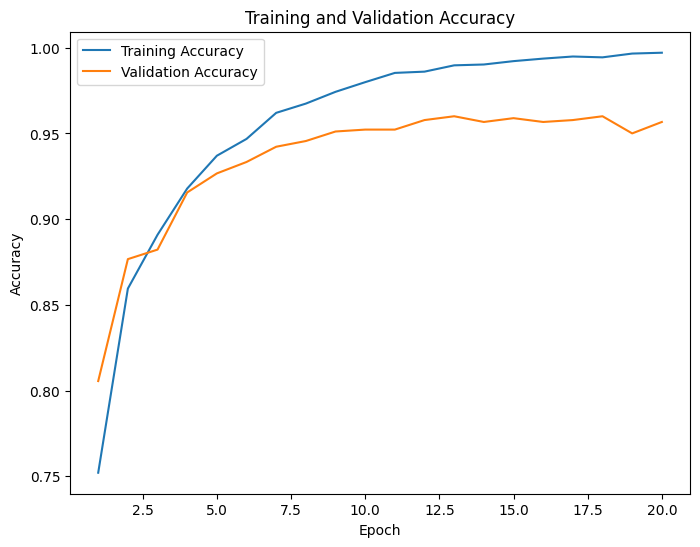

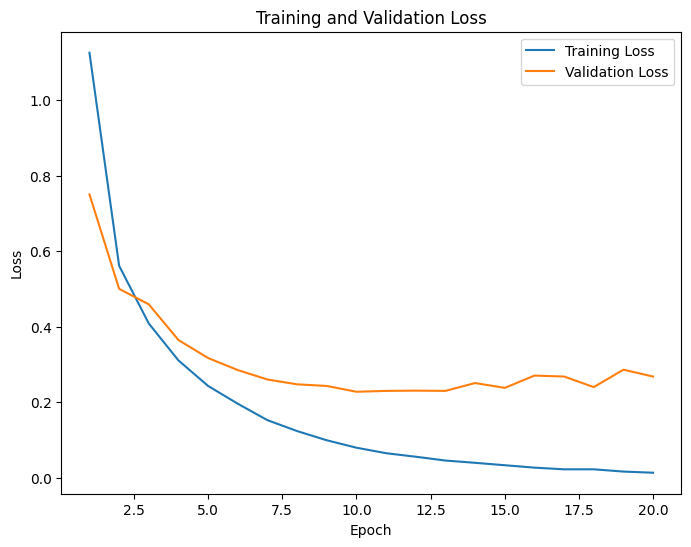

In [67]:
model = Sequential()

model.add(Embedding( vocab_size,embedding_dim)) #layer 1

#convulutional layer
model.add(Conv1D(128, 5, activation='relu')) 

model.add(GlobalAveragePooling1D()) #layer 2
model.add(Dense(128, activation='relu')) #layer 3
model.add(Dense(22,activation='softmax')) #layer 4

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 20
history = model.fit(train_pad_sequences, train_encoded_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_pad_sequences, val_encoded_labels))

# print the train and validation accuracy
plot_accuracy(history)
plot_loss(history)



## Experiment 4: Xarxes Recurrents

## Experiment 5: Regularització

## Experiment 6: Balancejat de Clases


<h1><a name="section-four"> 4. Lliurable </a></h1>

Heu d'entregar un document PDF de com a **màxim 10 pàgines** que incloga els resultats de tots els exercicis així com una explicació de cadascun dels resultats i de la modificació que heu fet. L'estructura del document és:

1. Introducció.
2. Experiments i Resultats (amb raonament).
3. Conclusions.

No cal que afegiu el vostre codi al document, podeu entregar el *notebook* juntament amb el document.

 ---